In [1]:
import numpy as np
import pandas as pd

from pyNBA.Data.data import QueryData
# from pyNBA.Models.ownership import OwnershipModel
# from pyNBA.Models.variance import VarianceModel
# from pyNBA.Models.constants import OWNERSHIP_PRIMARY_COLS, VARIANCE_PRIMARY_COLS
from pyNBA.DFS.constants import Site
from pyNBA.Backtest.data import GetData
from pyNBA.Backtest.contests import slate_contests_to_enter, get_prizes
from pyNBA.Backtest.lineups import GetLineups

import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
max_slate_value = 300
max_contest_value = 100
min_contest_fee = 1
max_contest_fee = 25
min_contest_total_entries = 100
max_contest_entries = 20

In [3]:
backtest_data = GetData(Site.DRAFTKINGS)
all_contest_data = backtest_data.get_contest_data(max_contest_entries, max_contest_value)
player_data = backtest_data.get_player_data()
all_contest_results = backtest_data.get_contest_results()

get_lineups = GetLineups()

/Users/brandonshimiaie/Projects/pyNBA/sqlite/db/nba.db
2.6.0


In [4]:
results = pd.DataFrame(columns = [
    'DATE', 'GAME_COUNT', 'MAX_ENTRIES', 'TOTAL_ENTRIES',
    'ENTRY_FEE', 'CASHLINE', 'LINEUP_TYPE', 'SCORE',
    'TOP_SCORE', 'PRIZE', 'TOP_PRIZE'
])
pnl_1_list = []
pnl_2_list = []

for season, season_data in player_data.groupby('SEASON'):

    # get projections
#     train_data = player_data.loc[player_data['SEASON'] != season]

#     ownership_model = OwnershipModel(train_data, season_data)
#     ownership_projections = ownership_model.predict()
#     season_data = season_data.merge(ownership_projections, on=OWNERSHIP_PRIMARY_COLS, how='left')

#     variance_model = VarianceModel(train_data, season_data)
#     variance_projections = variance_model.predict()
#     season_data = season_data.merge(variance_projections, on=VARIANCE_PRIMARY_COLS, how='left')

    # iterate through each slate
    season_contest_data = all_contest_data.loc[all_contest_data['DATE'].isin(set(season_data['DATE'].unique()))]
    for (date, slate_id), slate_data in season_contest_data.groupby(['DATE', 'SLATEID']):
        print(pd.to_datetime('now'), date, int(np.sum(pnl_1_list)), int(np.sum(pnl_2_list)))

        slate_players = season_data.loc[season_data['SLATEID'] == slate_id]
        if slate_players.empty:
            continue
        
        valid_contests = slate_contests_to_enter(
            slate_data, max_slate_value, max_contest_value, min_contest_fee,
            max_contest_fee, min_contest_total_entries
        )
        slate_data = slate_data.loc[slate_data['CONTESTID'].isin(valid_contests)]
        if slate_data.empty:
            continue
        slate_data = slate_data.sort_values(by='ENTRYFEE', ascending=False)
        total_entries = slate_data['MAXENTRIES'].sum()

        lineups = get_lineups.get_best_lineups_v1(slate_players, total_entries)
        entered_idx = 0

        # iterate through each contest
        for _, contest_data in slate_data.iterrows():
            contest_results = all_contest_results.loc[all_contest_results['CONTESTID'] == contest_data['CONTESTID']]
            if contest_results.empty:
                continue

            result = {} 
            result['DATE'] = date
            result['GAME_COUNT'] = contest_data['GAMECOUNT']
            result['MAX_ENTRIES'] = contest_data['MAXENTRIES']
            result['TOTAL_ENTRIES'] = contest_data['TOTALENTRIES']
            result['ENTRY_FEE'] = contest_data['ENTRYFEE']
            result['CASHLINE'] = contest_data['CASHLINE']
            result['TOP_PRIZE'] = contest_data['TOPPRIZE']
            result['TOP_SCORE'] = contest_data['TOPSCORE']
            
            max_entries = int(contest_data['MAXENTRIES'])
            top_lineups = lineups.iloc[0:max_entries]
            top_lineup_prizes = get_prizes(top_lineups, contest_results)
            result['LINEUP_TYPE'] = 1
            for _, lineup_prize in top_lineup_prizes.iterrows():
                result['SCORE'] = lineup_prize['REALSCORE']
                result['PRIZE'] = lineup_prize['PRIZE']
                results = results.append(result, ignore_index=True)
                pnl = result['PRIZE'] - result['ENTRY_FEE']
                pnl_1_list.append(pnl)
            
            top_lineups = lineups.iloc[entered_idx:entered_idx+max_entries]
            top_lineup_prizes = get_prizes(top_lineups, contest_results)
            entered_idx += max_entries
            result['LINEUP_TYPE'] = 2
            for _, lineup_prize in top_lineup_prizes.iterrows():
                result['SCORE'] = lineup_prize['REALSCORE']
                result['PRIZE'] = lineup_prize['PRIZE']
                results = results.append(result, ignore_index=True)
                pnl = result['PRIZE'] - result['ENTRY_FEE']
                pnl_2_list.append(pnl)


2021-08-29 00:34:21.499123 2017-10-18 0 0
2021-08-29 00:34:27.493571 2017-10-18 88 78
2021-08-29 00:34:28.548747 2017-10-18 7 -34
2021-08-29 00:34:29.659831 2017-10-19 102 -5
2021-08-29 00:34:33.173603 2017-10-19 398 191
2021-08-29 00:34:33.696109 2017-10-20 390 183
2021-08-29 00:34:34.202016 2017-10-20 310 103
2021-08-29 00:34:40.555842 2017-10-20 106 -91
2021-08-29 00:34:41.058976 2017-10-20 142 -55
2021-08-29 00:34:41.632747 2017-10-21 134 -63
2021-08-29 00:34:49.214694 2017-10-21 -124 -278
2021-08-29 00:34:49.816619 2017-10-22 -105 -260
2021-08-29 00:34:51.651816 2017-10-22 -265 -388
2021-08-29 00:34:55.997157 2017-10-23 -305 -366
2021-08-29 00:35:00.970470 2017-10-23 -557 -611
2021-08-29 00:35:02.010165 2017-10-23 -558 -617
2021-08-29 00:35:02.519471 2017-10-24 -620 -679
2021-08-29 00:35:10.662464 2017-10-24 -906 -954
2021-08-29 00:35:13.282447 2017-10-24 -1138 -1174
2021-08-29 00:35:13.853686 2017-10-25 -1228 -1264
2021-08-29 00:35:26.264607 2017-10-25 -1446 -1467
2021-08-29 00:3

2021-08-29 00:44:10.935137 2017-12-26 7963 8152
2021-08-29 00:44:11.350311 2017-12-27 7909 8098
2021-08-29 00:44:19.468111 2017-12-27 7712 7953
2021-08-29 00:44:19.953587 2017-12-27 7628 7869
2021-08-29 00:44:22.725479 2017-12-28 8022 8332
2021-08-29 00:44:30.342701 2017-12-28 8038 8320
2021-08-29 00:44:31.874914 2017-12-29 7963 8193
2021-08-29 00:44:38.415230 2017-12-29 7749 7989
2021-08-29 00:44:40.436196 2017-12-29 7751 7997
2021-08-29 00:44:41.778351 2017-12-30 7635 7881
2021-08-29 00:44:43.444052 2017-12-30 7423 7674
2021-08-29 00:44:50.267009 2017-12-31 7318 7549
2021-08-29 00:44:56.556351 2017-12-31 7486 7679
2021-08-29 00:44:59.152212 2018-01-01 7582 7748
2021-08-29 00:45:00.724082 2018-01-01 7422 7576
2021-08-29 00:45:09.190390 2018-01-02 7216 7376
2021-08-29 00:45:11.103519 2018-01-02 7144 7288
2021-08-29 00:45:14.241177 2018-01-02 6941 7097
2021-08-29 00:45:15.320997 2018-01-03 6842 6998
2021-08-29 00:45:17.177926 2018-01-03 6704 6923
2021-08-29 00:45:30.247378 2018-01-04 64

2021-08-29 00:56:11.104572 2018-03-09 52850 49785
2021-08-29 00:56:12.455803 2018-03-10 52773 49711
2021-08-29 00:56:14.944174 2018-03-10 52720 49650
2021-08-29 00:56:20.891531 2018-03-11 53123 49876
2021-08-29 00:56:24.682969 2018-03-11 52850 49609
2021-08-29 00:56:27.954926 2018-03-11 52868 49625
2021-08-29 00:56:29.302871 2018-03-12 52754 49518
2021-08-29 00:56:33.955435 2018-03-13 52558 49300
2021-08-29 00:56:40.490947 2018-03-13 52562 49279
2021-08-29 00:56:42.925704 2018-03-13 52437 49180
2021-08-29 00:56:44.374806 2018-03-14 52529 49265
2021-08-29 00:56:46.594706 2018-03-14 52358 49096
2021-08-29 00:56:50.693822 2018-03-15 52130 48873
2021-08-29 00:56:59.913714 2018-03-15 52002 48780
2021-08-29 00:57:03.150610 2018-03-15 52572 48978
2021-08-29 00:57:04.489091 2018-03-16 52485 48891
2021-08-29 00:57:11.175069 2018-03-16 52393 48797
2021-08-29 00:57:14.344575 2018-03-17 52173 48588
2021-08-29 00:57:23.507699 2018-03-17 51998 48409
2021-08-29 00:57:26.666263 2018-03-17 51759 48201


2021-08-29 01:07:32.941834 2018-11-17 89004 81562
2021-08-29 01:07:34.868806 2018-11-18 89372 81776
2021-08-29 01:07:39.753928 2018-11-19 89315 81664
2021-08-29 01:07:45.110201 2018-11-19 89221 81559
2021-08-29 01:07:47.266947 2018-11-20 89001 81339
2021-08-29 01:07:52.967217 2018-11-20 88853 81182
2021-08-29 01:07:56.016175 2018-11-21 88663 81005
2021-08-29 01:08:11.447994 2018-11-21 88766 81103
2021-08-29 01:08:13.245060 2018-11-21 88784 81110
2021-08-29 01:08:16.382009 2018-11-23 90452 82371
2021-08-29 01:08:25.612589 2018-11-23 90206 82129
2021-08-29 01:08:29.732564 2018-11-23 89996 82075
2021-08-29 01:08:31.497985 2018-11-23 89880 81959
2021-08-29 01:08:37.526890 2018-11-24 89700 81807
2021-08-29 01:08:47.643528 2018-11-24 89614 81691
2021-08-29 01:08:49.648854 2018-11-24 89394 81471
2021-08-29 01:08:50.641686 2018-11-25 89382 81459
2021-08-29 01:08:53.272607 2018-11-25 89235 81309
2021-08-29 01:08:57.416707 2018-11-25 89042 81121
2021-08-29 01:09:00.147095 2018-11-26 88893 80979


2021-08-29 01:18:46.781455 2019-01-19 91426 82875
2021-08-29 01:18:49.533045 2019-01-19 91246 82700
2021-08-29 01:18:50.147859 2019-01-20 91150 82604
2021-08-29 01:18:55.441572 2019-01-20 91210 82656
2021-08-29 01:18:55.977341 2019-01-21 91155 82601
2021-08-29 01:19:01.377206 2019-01-21 91003 82424
2021-08-29 01:19:06.357005 2019-01-21 92669 83317
2021-08-29 01:19:12.260464 2019-01-22 92444 83112
2021-08-29 01:19:18.691259 2019-01-22 92394 83020
2021-08-29 01:19:21.435893 2019-01-23 92275 82945
2021-08-29 01:19:30.336877 2019-01-23 92101 82779
2021-08-29 01:19:34.234038 2019-01-24 91855 82880
2021-08-29 01:19:40.134871 2019-01-24 91963 82952
2021-08-29 01:19:43.594680 2019-01-25 92153 83264
2021-08-29 01:19:51.865298 2019-01-25 91859 82968
2021-08-29 01:19:54.221129 2019-01-25 91833 82942
2021-08-29 01:19:57.062059 2019-01-26 91651 82715
2021-08-29 01:20:03.601248 2019-01-26 91431 82512
2021-08-29 01:20:06.347531 2019-01-27 91301 82385
2021-08-29 01:20:11.370471 2019-01-27 91220 82288


2021-08-29 01:30:54.835319 2019-03-29 101201 95387
2021-08-29 01:30:58.047243 2019-03-29 101021 95209
2021-08-29 01:30:58.749188 2019-03-30 100937 95125
2021-08-29 01:31:03.410364 2019-03-30 101424 95347
2021-08-29 01:31:05.043482 2019-03-30 101811 95814
2021-08-29 01:31:08.401271 2019-03-31 101598 95561
2021-08-29 01:31:12.052717 2019-03-31 101426 95397
2021-08-29 01:31:15.221701 2019-03-31 126320 118416
2021-08-29 01:31:18.219969 2019-04-01 126168 118271
2021-08-29 01:31:24.499001 2019-04-01 125961 118083
2021-08-29 01:31:25.195183 2019-04-01 125865 117987
2021-08-29 01:31:28.290847 2019-04-02 125740 117872
2021-08-29 01:31:33.498108 2019-04-02 125678 117786
2021-08-29 01:31:35.465731 2019-04-03 125438 117553
2021-08-29 01:31:42.319963 2019-04-03 125303 117444
2021-08-29 01:31:46.453454 2019-04-03 125379 117579
2021-08-29 01:31:47.149302 2019-04-04 125310 117510
2021-08-29 01:31:53.831112 2019-04-04 125354 117612
2021-08-29 01:31:58.410530 2019-04-05 126901 119546
2021-08-29 01:32:07

2021-08-29 01:44:59.156184 2019-12-11 122014 116403
2021-08-29 01:45:02.470647 2019-12-11 122009 116374
2021-08-29 01:45:04.545778 2019-12-11 122115 116464
2021-08-29 01:45:06.817799 2019-12-12 122151 116495
2021-08-29 01:45:14.429532 2019-12-12 121919 116262
2021-08-29 01:45:17.850869 2019-12-13 121719 116062
2021-08-29 01:45:32.444566 2019-12-13 121462 115807
2021-08-29 01:45:34.123244 2019-12-13 121561 115911
2021-08-29 01:45:34.887450 2019-12-14 121465 115815
2021-08-29 01:45:46.381855 2019-12-14 122289 116670
2021-08-29 01:45:49.665282 2019-12-14 123758 118797
2021-08-29 01:45:50.440875 2019-12-15 123832 118871
2021-08-29 01:45:56.067870 2019-12-15 124916 121079
2021-08-29 01:45:57.963840 2019-12-15 124815 120980
2021-08-29 01:45:59.204626 2019-12-16 124848 121012
2021-08-29 01:46:08.292398 2019-12-16 124591 120765
2021-08-29 01:46:10.870524 2019-12-17 124471 120645
2021-08-29 01:46:21.393172 2019-12-17 124505 120650
2021-08-29 01:46:26.502869 2019-12-17 124362 120493
2021-08-29 0

2021-08-29 01:59:57.437294 2020-02-08 141003 138121
2021-08-29 01:59:58.261202 2020-02-09 140907 138025
2021-08-29 02:00:10.305245 2020-02-09 140648 137796
2021-08-29 02:00:14.053461 2020-02-10 140368 137518
2021-08-29 02:00:27.770946 2020-02-10 140129 137283
2021-08-29 02:00:31.438831 2020-02-10 139902 137095
2021-08-29 02:00:32.273021 2020-02-10 139830 137023
2021-08-29 02:00:33.097122 2020-02-11 139734 136927
2021-08-29 02:00:44.959210 2020-02-11 139769 136956
2021-08-29 02:00:48.803390 2020-02-12 139816 136923
2021-08-29 02:01:03.298732 2020-02-12 139701 136783
2021-08-29 02:01:05.281587 2020-02-12 139622 136704
2021-08-29 02:01:07.570280 2020-02-12 142213 139179
2021-08-29 02:01:08.403822 2020-02-13 142129 139095
2021-08-29 02:01:10.654266 2020-02-20 142079 139067
2021-08-29 02:01:21.991674 2020-02-20 141872 138907
2021-08-29 02:01:24.179690 2020-02-20 141825 138862
2021-08-29 02:01:27.525552 2020-02-21 142034 140339
2021-08-29 02:01:39.371933 2020-02-21 141797 140102
2021-08-29 0

2021-08-29 02:14:56.954736 2017-11-17 147879 143457
2021-08-29 02:14:57.875706 2017-11-17 147846 143424
2021-08-29 02:14:58.783605 2017-11-18 147877 143455
2021-08-29 02:15:09.531128 2017-11-18 147997 143508
2021-08-29 02:15:14.456203 2017-11-19 147705 143224
2021-08-29 02:15:16.819663 2017-11-19 147700 143213
2021-08-29 02:15:20.771121 2017-11-19 147937 143419
2021-08-29 02:15:25.221853 2017-11-20 147799 143293
2021-08-29 02:15:31.256053 2017-11-20 148105 143550
2021-08-29 02:15:33.716575 2017-11-20 148091 143528
2021-08-29 02:15:34.649665 2017-11-22 148529 143966
2021-08-29 02:15:49.887652 2017-11-22 148439 143813
2021-08-29 02:15:55.621320 2017-11-22 148310 143736
2021-08-29 02:15:56.615173 2017-11-24 148354 143780
2021-08-29 02:16:04.817268 2017-11-24 148098 143526
2021-08-29 02:16:08.944298 2017-11-24 147940 143359
2021-08-29 02:16:11.898258 2017-11-25 148506 143898
2021-08-29 02:16:26.393637 2017-11-25 148267 143665
2021-08-29 02:16:28.802907 2017-11-25 148277 143680
2021-08-29 0

2021-08-29 02:31:35.964395 2018-01-21 155890 153813
2021-08-29 02:31:41.373557 2018-01-22 155658 153609
2021-08-29 02:31:46.756365 2018-01-22 155916 153792
2021-08-29 02:31:49.669132 2018-01-22 155879 153754
2021-08-29 02:32:04.285655 2018-01-23 155598 153497
2021-08-29 02:32:17.176815 2018-01-23 155442 153362
2021-08-29 02:32:23.649746 2018-01-23 155637 153524
2021-08-29 02:32:26.221996 2018-01-24 155527 153434
2021-08-29 02:32:41.597453 2018-01-24 155733 153711
2021-08-29 02:32:44.189121 2018-01-24 155803 153770
2021-08-29 02:32:48.946031 2018-01-25 155693 153694
2021-08-29 02:32:54.724592 2018-01-25 155492 153571
2021-08-29 02:33:05.395298 2018-01-26 155232 153363
2021-08-29 02:33:20.250558 2018-01-26 155056 153242
2021-08-29 02:33:24.081208 2018-01-26 154872 153082
2021-08-29 02:33:26.817115 2018-01-27 154756 152968
2021-08-29 02:33:37.947377 2018-01-27 154864 153071
2021-08-29 02:33:43.937223 2018-01-28 154720 152909
2021-08-29 02:33:55.340463 2018-01-28 154519 152672
2021-08-29 0

2021-08-29 02:50:32.948383 2018-04-03 194985 190671
2021-08-29 02:50:49.314489 2018-04-03 194962 190642
2021-08-29 02:50:50.399185 2018-04-03 194881 190561
2021-08-29 02:50:51.539399 2018-04-04 194871 190551
2021-08-29 02:50:59.453443 2018-04-04 194619 190328
2021-08-29 02:51:02.292183 2018-04-05 194523 190228
2021-08-29 02:51:05.419651 2018-04-05 194235 189940
2021-08-29 02:51:13.900527 2018-04-06 194030 189735
2021-08-29 02:51:19.622720 2018-04-06 193880 189547
2021-08-29 02:51:25.933978 2018-04-07 193675 189344
2021-08-29 02:51:29.909874 2018-04-07 193508 189192
2021-08-29 02:51:36.993447 2018-04-08 193436 189094
2021-08-29 02:51:43.976485 2018-04-08 193200 188872
2021-08-29 02:51:52.054723 2018-04-09 192908 188580
2021-08-29 02:51:58.324692 2018-04-09 192892 188560
2021-08-29 02:51:59.397753 2018-04-09 192808 188476
2021-08-29 02:52:03.344533 2018-04-10 192852 188465
2021-08-29 02:52:03.363064 2018-04-10 192852 188465
2021-08-29 02:52:06.182204 2018-04-10 192910 188533
2021-08-29 0

2021-08-29 03:08:21.419666 2018-12-10 228039 218864
2021-08-29 03:08:34.013267 2018-12-10 227814 218758
2021-08-29 03:08:40.104728 2018-12-10 227571 218512
2021-08-29 03:08:41.246193 2018-12-10 227512 218453
2021-08-29 03:08:42.374846 2018-12-11 227645 218586
2021-08-29 03:08:50.922507 2018-12-11 227424 218386
2021-08-29 03:08:53.001739 2018-12-12 227414 218376
2021-08-29 03:09:04.389473 2018-12-12 227260 218243
2021-08-29 03:09:09.016807 2018-12-12 227072 218068
2021-08-29 03:09:14.056608 2018-12-13 226909 217904
2021-08-29 03:09:20.475825 2018-12-13 226752 217764
2021-08-29 03:09:26.232789 2018-12-14 226472 217484
2021-08-29 03:09:33.630863 2018-12-14 226520 217558
2021-08-29 03:09:34.816745 2018-12-14 226533 217571
2021-08-29 03:09:40.266567 2018-12-15 226506 217506
2021-08-29 03:09:41.434223 2018-12-15 226519 217519
2021-08-29 03:09:47.993624 2018-12-15 226694 217773
2021-08-29 03:09:51.791254 2018-12-16 226551 217643
2021-08-29 03:09:56.790208 2018-12-16 226563 217658
2021-08-29 0

2021-08-29 03:25:46.110939 2019-02-07 230248 225633
2021-08-29 03:25:57.990759 2019-02-07 230261 225602
2021-08-29 03:26:02.794642 2019-02-08 230326 225649
2021-08-29 03:26:17.164146 2019-02-08 230070 225393
2021-08-29 03:26:18.374192 2019-02-08 229974 225297
2021-08-29 03:26:22.432735 2019-02-09 229863 225185
2021-08-29 03:26:23.686102 2019-02-09 229767 225089
2021-08-29 03:26:35.023659 2019-02-09 229471 224795
2021-08-29 03:26:41.362272 2019-02-10 229288 224617
2021-08-29 03:26:48.628235 2019-02-10 229139 224570
2021-08-29 03:26:57.324761 2019-02-10 228949 224400
2021-08-29 03:27:02.306209 2019-02-11 228959 224376
2021-08-29 03:27:15.016720 2019-02-11 228742 224159
2021-08-29 03:27:18.038769 2019-02-12 228626 224043
2021-08-29 03:27:32.547959 2019-02-12 228394 223811
2021-08-29 03:27:38.861989 2019-02-13 228114 223531
2021-08-29 03:27:46.555547 2019-02-13 228558 223902
2021-08-29 03:27:59.888084 2019-02-13 228348 223696
2021-08-29 03:28:01.134729 2019-02-13 228279 223627
2021-08-29 0

2021-08-29 03:44:08.998009 2019-10-26 268135 260308
2021-08-29 03:44:22.848996 2019-10-26 267918 260091
2021-08-29 03:44:28.208261 2019-10-26 267718 259900
2021-08-29 03:44:31.683920 2019-10-27 267605 259789
2021-08-29 03:44:40.948184 2019-10-27 267800 260067
2021-08-29 03:44:44.260100 2019-10-28 267821 260087
2021-08-29 03:45:00.964999 2019-10-28 267795 259991
2021-08-29 03:45:10.633952 2019-10-28 267814 259969
2021-08-29 03:45:11.972964 2019-10-29 267766 259921
2021-08-29 03:45:22.391818 2019-10-29 267537 259686
2021-08-29 03:45:27.900696 2019-10-30 267337 259489
2021-08-29 03:45:47.554114 2019-10-30 267800 260067
2021-08-29 03:45:56.911117 2019-10-30 268280 260409
2021-08-29 03:46:02.437141 2019-10-31 268246 260394
2021-08-29 03:46:11.611306 2019-10-31 267993 260147
2021-08-29 03:46:18.772218 2019-11-01 267773 259934
2021-08-29 03:46:36.332427 2019-11-01 267777 259901
2021-08-29 03:46:44.571721 2019-11-01 268559 260800
2021-08-29 03:46:45.805679 2019-11-02 268463 260704
2021-08-29 0

2021-08-29 04:05:08.610160 2019-12-26 277835 268841
2021-08-29 04:05:16.102258 2019-12-26 277642 268699
2021-08-29 04:05:17.399218 2019-12-27 277664 268721
2021-08-29 04:05:32.454353 2019-12-27 277412 268470
2021-08-29 04:05:37.288869 2019-12-28 277267 268333
2021-08-29 04:06:02.514974 2019-12-28 277299 268406
2021-08-29 04:06:07.773057 2019-12-28 277126 268275
2021-08-29 04:06:09.154001 2019-12-28 277175 268324
2021-08-29 04:06:10.461993 2019-12-29 277079 268228
2021-08-29 04:06:24.264933 2019-12-30 277559 268662
2021-08-29 04:06:36.185325 2019-12-30 277341 268442
2021-08-29 04:06:39.559084 2019-12-30 277225 268326
2021-08-29 04:06:46.785155 2019-12-31 277268 268319
2021-08-29 04:06:58.811950 2019-12-31 277267 268355
2021-08-29 04:07:09.306900 2020-01-01 277025 268146
2021-08-29 04:07:19.683329 2020-01-01 277050 268107
2021-08-29 04:07:31.021508 2020-01-02 276825 267888
2021-08-29 04:07:43.727809 2020-01-02 279853 276121
2021-08-29 04:07:47.142419 2020-01-02 279741 276017
2021-08-29 0

2021-08-29 04:26:16.540741 2020-02-28 281255 277990
2021-08-29 04:26:19.155035 2020-02-28 281063 277798
2021-08-29 04:26:20.606771 2020-02-28 280967 277702
2021-08-29 04:26:26.589217 2020-02-29 280810 277539
2021-08-29 04:26:43.547379 2020-02-29 280547 277286
2021-08-29 04:26:48.944470 2020-02-29 280357 277096
2021-08-29 04:26:50.315343 2020-03-01 280261 277000
2021-08-29 04:27:01.108123 2020-03-01 280089 276872
2021-08-29 04:27:07.390533 2020-03-01 280858 277481
2021-08-29 04:27:13.257721 2020-03-02 280928 277539
2021-08-29 04:27:28.701068 2020-03-02 281027 277624
2021-08-29 04:27:34.444383 2020-03-02 280837 277408
2021-08-29 04:27:35.780768 2020-03-03 280741 277312
2021-08-29 04:27:49.308108 2020-03-03 281358 279187
2021-08-29 04:27:55.303648 2020-03-03 281073 278909
2021-08-29 04:27:56.647284 2020-03-03 281004 278840
2021-08-29 04:27:57.993733 2020-03-04 281079 278915
2021-08-29 04:28:10.593391 2020-03-04 280930 278787
2021-08-29 04:28:14.826099 2020-03-04 280942 278649
2021-08-29 0

2021-08-29 04:47:31.570768 2017-12-05 290575 286639
2021-08-29 04:47:31.596251 2017-12-05 290575 286639
2021-08-29 04:47:35.312323 2017-12-06 290459 286523
2021-08-29 04:47:59.780588 2017-12-06 290846 286770
2021-08-29 04:48:07.535343 2017-12-06 290659 286554
2021-08-29 04:48:08.974825 2017-12-07 290647 286542
2021-08-29 04:48:25.037116 2017-12-07 290354 286249
2021-08-29 04:48:30.987103 2017-12-08 290158 286053
2021-08-29 04:48:48.259108 2017-12-08 289877 285820
2021-08-29 04:48:53.635579 2017-12-09 289666 285629
2021-08-29 04:49:12.369586 2017-12-09 289715 285677
2021-08-29 04:49:22.998704 2017-12-09 289651 285782
2021-08-29 04:49:26.914161 2017-12-10 289877 285976
2021-08-29 04:49:34.867869 2017-12-10 289816 285987
2021-08-29 04:49:38.648540 2017-12-11 289670 285867
2021-08-29 04:49:44.867372 2017-12-11 289661 285835
2021-08-29 04:49:58.657701 2017-12-12 289542 285857
2021-08-29 04:50:14.416282 2017-12-12 289439 285675
2021-08-29 04:50:22.307596 2017-12-12 292564 288950
2021-08-29 0

2021-08-29 05:12:33.648790 2018-02-06 300723 296921
2021-08-29 05:12:46.019483 2018-02-07 300427 296625
2021-08-29 05:12:50.278720 2018-02-07 300404 296609
2021-08-29 05:13:01.261934 2018-02-08 300530 296815
2021-08-29 05:13:18.063086 2018-02-08 301434 297630
2021-08-29 05:13:26.114372 2018-02-08 301607 298832
2021-08-29 05:13:29.959277 2018-02-09 301827 299097
2021-08-29 05:13:38.001671 2018-02-09 301685 298999
2021-08-29 05:13:38.028795 2018-02-09 301685 298999
2021-08-29 05:13:41.889727 2018-02-10 301659 298975
2021-08-29 05:13:56.234071 2018-02-10 301505 298851
2021-08-29 05:14:04.762849 2018-02-11 301233 298625
2021-08-29 05:14:17.141031 2018-02-11 301006 298387
2021-08-29 05:14:27.494732 2018-02-12 301043 298464
2021-08-29 05:14:40.641474 2018-02-12 300786 298207
2021-08-29 05:14:47.108184 2018-02-13 300599 298027
2021-08-29 05:14:58.074358 2018-02-13 300570 297967
2021-08-29 05:15:04.583780 2018-02-14 300605 297981
2021-08-29 05:15:28.073854 2018-02-14 330850 325485
2021-08-29 0

2021-08-29 05:37:11.149074 2018-10-24 344425 338071
2021-08-29 05:37:20.841334 2018-10-24 344227 337876
2021-08-29 05:37:33.446678 2018-10-24 345446 339107
2021-08-29 05:37:41.995985 2018-10-25 345468 339207
2021-08-29 05:37:53.067220 2018-10-25 345448 339218
2021-08-29 05:38:01.844728 2018-10-26 345246 339089
2021-08-29 05:38:14.531226 2018-10-26 345334 339094
2021-08-29 05:38:23.664635 2018-10-26 346142 339845
2021-08-29 05:38:25.219522 2018-10-27 346073 339776
2021-08-29 05:38:38.615800 2018-10-27 347712 342488
2021-08-29 05:38:46.884204 2018-10-27 347643 342436
2021-08-29 05:38:48.473718 2018-10-28 347654 342447
2021-08-29 05:38:56.642569 2018-10-29 347535 342336
2021-08-29 05:39:09.205994 2018-10-29 347521 342359
2021-08-29 05:39:14.813087 2018-10-29 347314 342184
2021-08-29 05:39:19.538450 2018-10-30 349739 343067
2021-08-29 05:39:36.464485 2018-10-30 351153 343663
2021-08-29 05:39:45.424219 2018-10-31 350989 343616
2021-08-29 05:40:06.542212 2018-10-31 350755 343382
2021-08-29 0

2021-08-29 06:00:00.339802 2018-12-25 366787 356806
2021-08-29 06:00:21.834971 2018-12-25 366545 356566
2021-08-29 06:00:40.006278 2018-12-26 366386 356381
2021-08-29 06:00:48.764398 2018-12-26 366150 356143
2021-08-29 06:01:05.186808 2018-12-26 366060 356117
2021-08-29 06:01:11.138408 2018-12-27 375528 364694
2021-08-29 06:01:30.173121 2018-12-27 375505 364702
2021-08-29 06:01:41.615110 2018-12-28 375459 364659
2021-08-29 06:01:53.986412 2018-12-28 375369 364514
2021-08-29 06:02:01.269101 2018-12-28 375271 364436
2021-08-29 06:02:09.848678 2018-12-29 375135 364276
2021-08-29 06:02:23.181044 2018-12-29 378527 366951
2021-08-29 06:02:24.817056 2018-12-29 378431 366855
2021-08-29 06:02:34.344319 2018-12-30 378444 366929
2021-08-29 06:02:43.082166 2018-12-30 378230 366715
2021-08-29 06:02:53.090564 2018-12-31 378073 366567
2021-08-29 06:03:05.907717 2018-12-31 377803 366297
2021-08-29 06:03:14.184472 2018-12-31 377520 366042
2021-08-29 06:03:16.023574 2019-01-01 377441 365968
2021-08-29 0

2021-08-29 06:23:57.209038 2019-02-28 376853 368849
2021-08-29 06:24:05.121569 2019-03-01 376639 368654
2021-08-29 06:24:24.690643 2019-03-01 376408 368425
2021-08-29 06:24:37.536616 2019-03-01 376148 368170
2021-08-29 06:24:40.307986 2019-03-02 376139 368160
2021-08-29 06:24:55.786405 2019-03-02 376177 368264
2021-08-29 06:25:03.698078 2019-03-02 375911 368019
2021-08-29 06:25:08.325527 2019-03-03 383134 374804
2021-08-29 06:25:18.716209 2019-03-03 383474 375078
2021-08-29 06:25:34.428029 2019-03-04 383312 374937
2021-08-29 06:25:53.188716 2019-03-04 383027 374668
2021-08-29 06:25:57.659984 2019-03-04 382911 374552
2021-08-29 06:26:04.965029 2019-03-05 382849 374520
2021-08-29 06:26:21.061989 2019-03-05 382911 374608
2021-08-29 06:26:28.157146 2019-03-06 382756 374456
2021-08-29 06:26:39.903127 2019-03-06 382540 374246
2021-08-29 06:26:47.503409 2019-03-06 382378 374039
2021-08-29 06:26:50.260296 2019-03-07 382318 373979
2021-08-29 06:27:05.947518 2019-03-08 382158 373840
2021-08-29 0

2021-08-29 06:49:07.317993 2019-11-10 407602 398308
2021-08-29 06:49:09.064777 2019-11-11 407643 398349
2021-08-29 06:49:23.421092 2019-11-11 409006 399595
2021-08-29 06:49:33.544327 2019-11-11 409583 400659
2021-08-29 06:49:35.289669 2019-11-12 409673 400749
2021-08-29 06:49:49.711128 2019-11-12 409532 400614
2021-08-29 06:49:51.463714 2019-11-13 409478 400560
2021-08-29 06:50:15.634253 2019-11-13 409440 400518
2021-08-29 06:50:26.187371 2019-11-13 409224 400309
2021-08-29 06:50:30.860710 2019-11-14 409140 400231
2021-08-29 06:50:53.778176 2019-11-14 408868 399963
2021-08-29 06:50:57.975718 2019-11-15 408689 399784
2021-08-29 06:51:14.447720 2019-11-15 408594 399751
2021-08-29 06:51:24.457600 2019-11-15 408379 399550
2021-08-29 06:51:29.249937 2019-11-16 408278 399451
2021-08-29 06:51:45.554912 2019-11-16 408250 399395
2021-08-29 06:51:52.952903 2019-11-16 408050 399201
2021-08-29 06:51:54.723323 2019-11-17 408068 399219
2021-08-29 06:52:06.527239 2019-11-17 407850 399009
2021-08-29 0

2021-08-29 07:16:31.832885 2020-01-11 426866 421291
2021-08-29 07:16:48.259573 2020-01-11 426976 421468
2021-08-29 07:16:52.723231 2020-01-11 426953 421449
2021-08-29 07:16:54.565308 2020-01-12 426951 421447
2021-08-29 07:17:06.964623 2020-01-12 426909 421362
2021-08-29 07:17:11.343337 2020-01-12 426956 421397
2021-08-29 07:17:18.886164 2020-01-13 426756 421206
2021-08-29 07:17:35.296193 2020-01-13 426570 421047
2021-08-29 07:17:46.023251 2020-01-13 426705 421191
2021-08-29 07:17:50.820799 2020-01-14 426612 421098
2021-08-29 07:18:10.523273 2020-01-14 426434 421017
2021-08-29 07:18:14.716673 2020-01-14 426294 420878
2021-08-29 07:18:19.411207 2020-01-15 426217 420797
2021-08-29 07:18:37.714505 2020-01-15 426053 420770
2021-08-29 07:18:47.518617 2020-01-15 425990 420748
2021-08-29 07:18:52.279898 2020-01-16 426064 420823
2021-08-29 07:19:13.723407 2020-01-16 426358 420994
2021-08-29 07:19:20.520005 2020-01-16 426301 420920
2021-08-29 07:19:25.345683 2020-01-17 426262 420876
2021-08-29 0

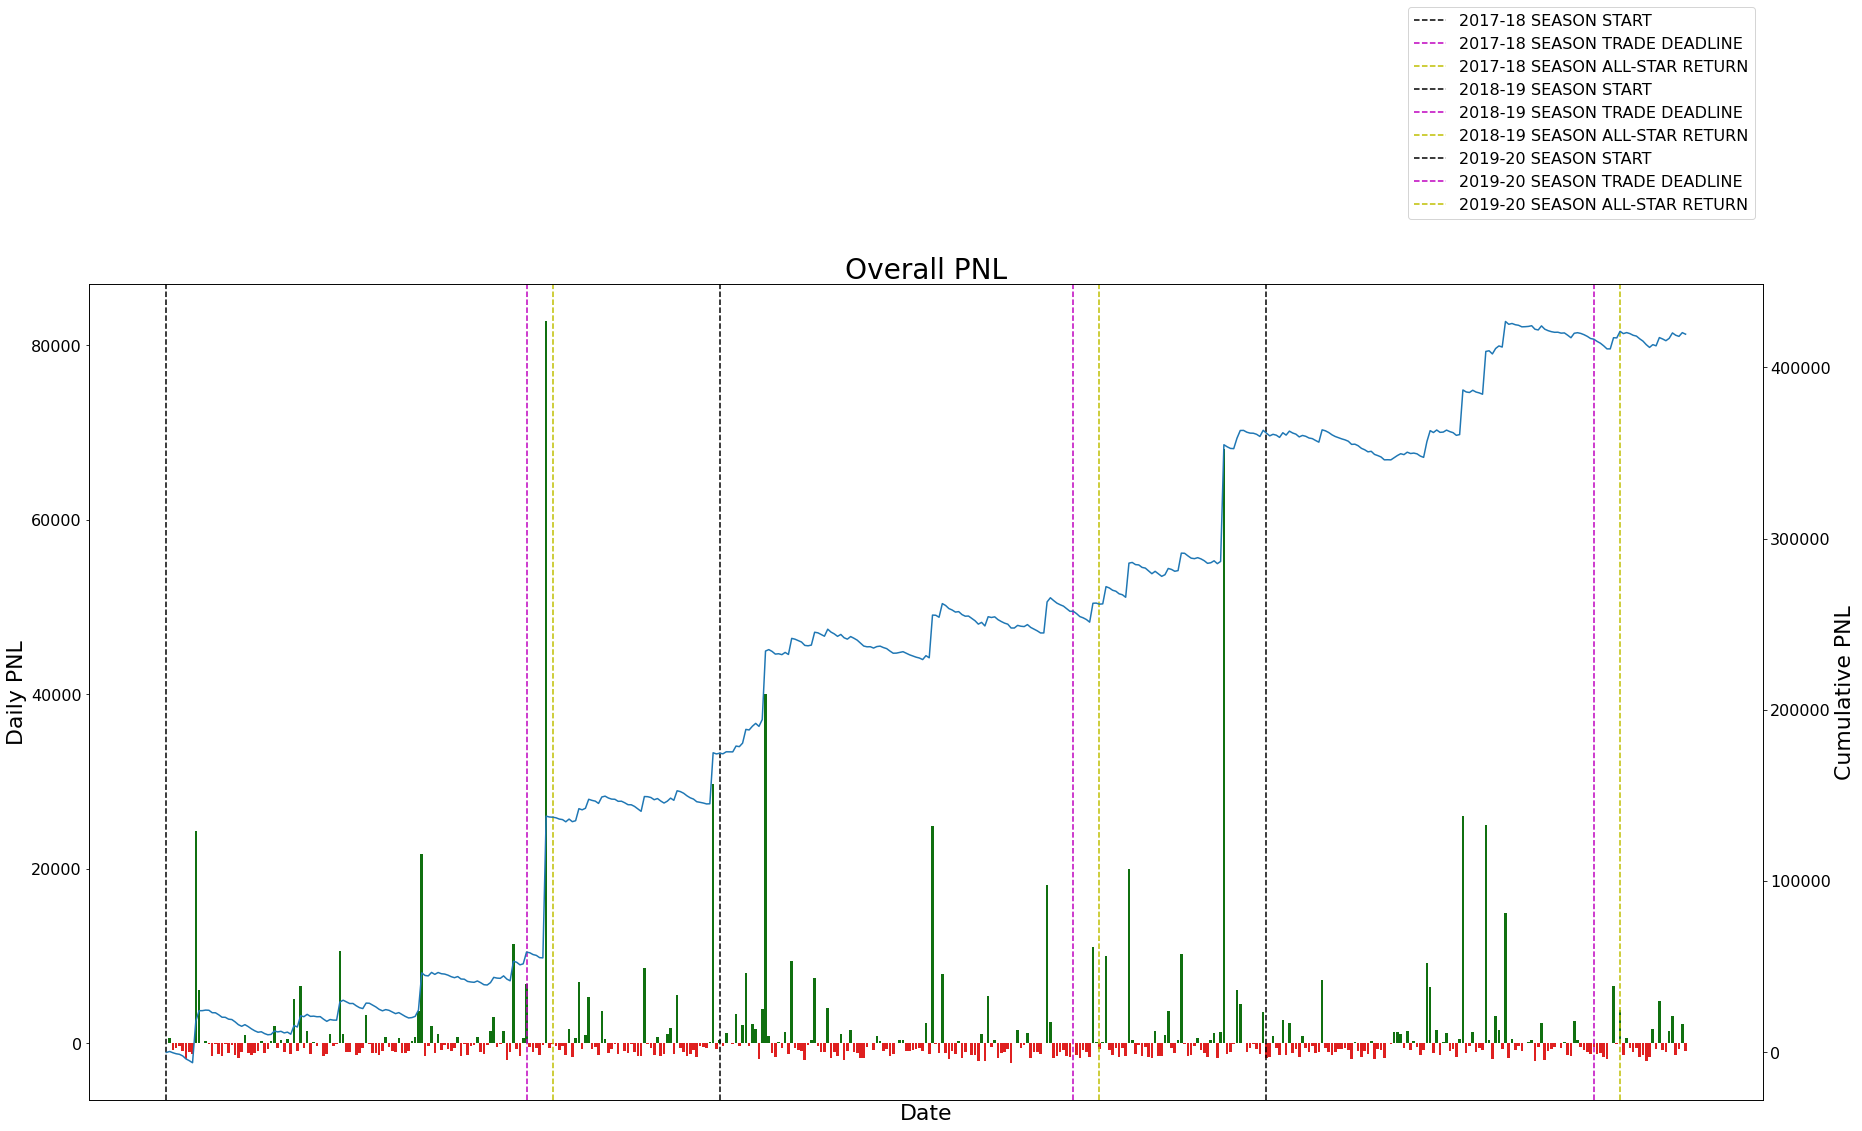

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(1, figsize=(30, 15))

# overall PNL
temp = results.loc[results['LINEUP_TYPE'] == 2]
temp['PNL'] = temp['PRIZE'] - temp['ENTRY_FEE']
pnl = temp.groupby(['DATE']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum(),
        'PNL': x['PNL'].sum()
    })
).reset_index()
pnl['RUNNING_PNL'] = pnl['PNL'].cumsum()

pnl['COLOR'] = pnl['PNL'].apply(lambda x: 'green' if x > 0 else 'red')
ax1 = sns.barplot(x=pnl.index, y='PNL', data=pnl, palette=pnl['COLOR'])
ax1.set_title('Overall PNL', fontsize=28)

xcoords = {
    pnl.index.min(): ('2017-18 SEASON START', 'k'),
    pnl.index[pnl['DATE'] == '2018-02-08'][0]: ('2017-18 SEASON TRADE DEADLINE', 'm'),
    pnl.index[pnl['DATE'] == '2018-02-22'][0]: ('2017-18 SEASON ALL-STAR RETURN', 'y'),
    pnl.index[pnl['DATE'] == '2018-10-19'][0]: ('2018-19 SEASON START', 'k'),
    pnl.index[pnl['DATE'] == '2019-02-07'][0]: ('2018-19 SEASON TRADE DEADLINE', 'm'),
    pnl.index[pnl['DATE'] == '2019-02-21'][0]: ('2018-19 SEASON ALL-STAR RETURN', 'y'),
    pnl.index[pnl['DATE'] == '2019-10-25'][0]: ('2019-20 SEASON START', 'k'),
    pnl.index[pnl['DATE'] == '2020-02-06'][0]: ('2019-20 SEASON TRADE DEADLINE', 'm'),
    pnl.index[pnl['DATE'] == '2020-02-20'][0]: ('2019-20 SEASON ALL-STAR RETURN', 'y'),
    
}
for xcoord in xcoords:
    ax1.axvline(x=xcoord, label=xcoords[xcoord][0], color=xcoords[xcoord][1], linestyle='dashed')
ax1.legend(bbox_to_anchor=(1, 1.35), loc='upper right', prop={'size': 16})

ax2 = ax1.twinx()
sns.lineplot(x=pnl.index, y='RUNNING_PNL', data=pnl, sort=False, color='tab:blue', ax=ax2)

ax1.set_xlabel('Date', fontsize=22)
ax1.set_ylabel('Daily PNL', fontsize=22)
ax2.set_ylabel('Cumulative PNL', fontsize=22)
ax1.set_xticks([])

ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='both', labelsize=16)

plt.show()

Break down ROI by contest type, entry fee, and number of games in the slate to determine where my projections generate the most return on investment.


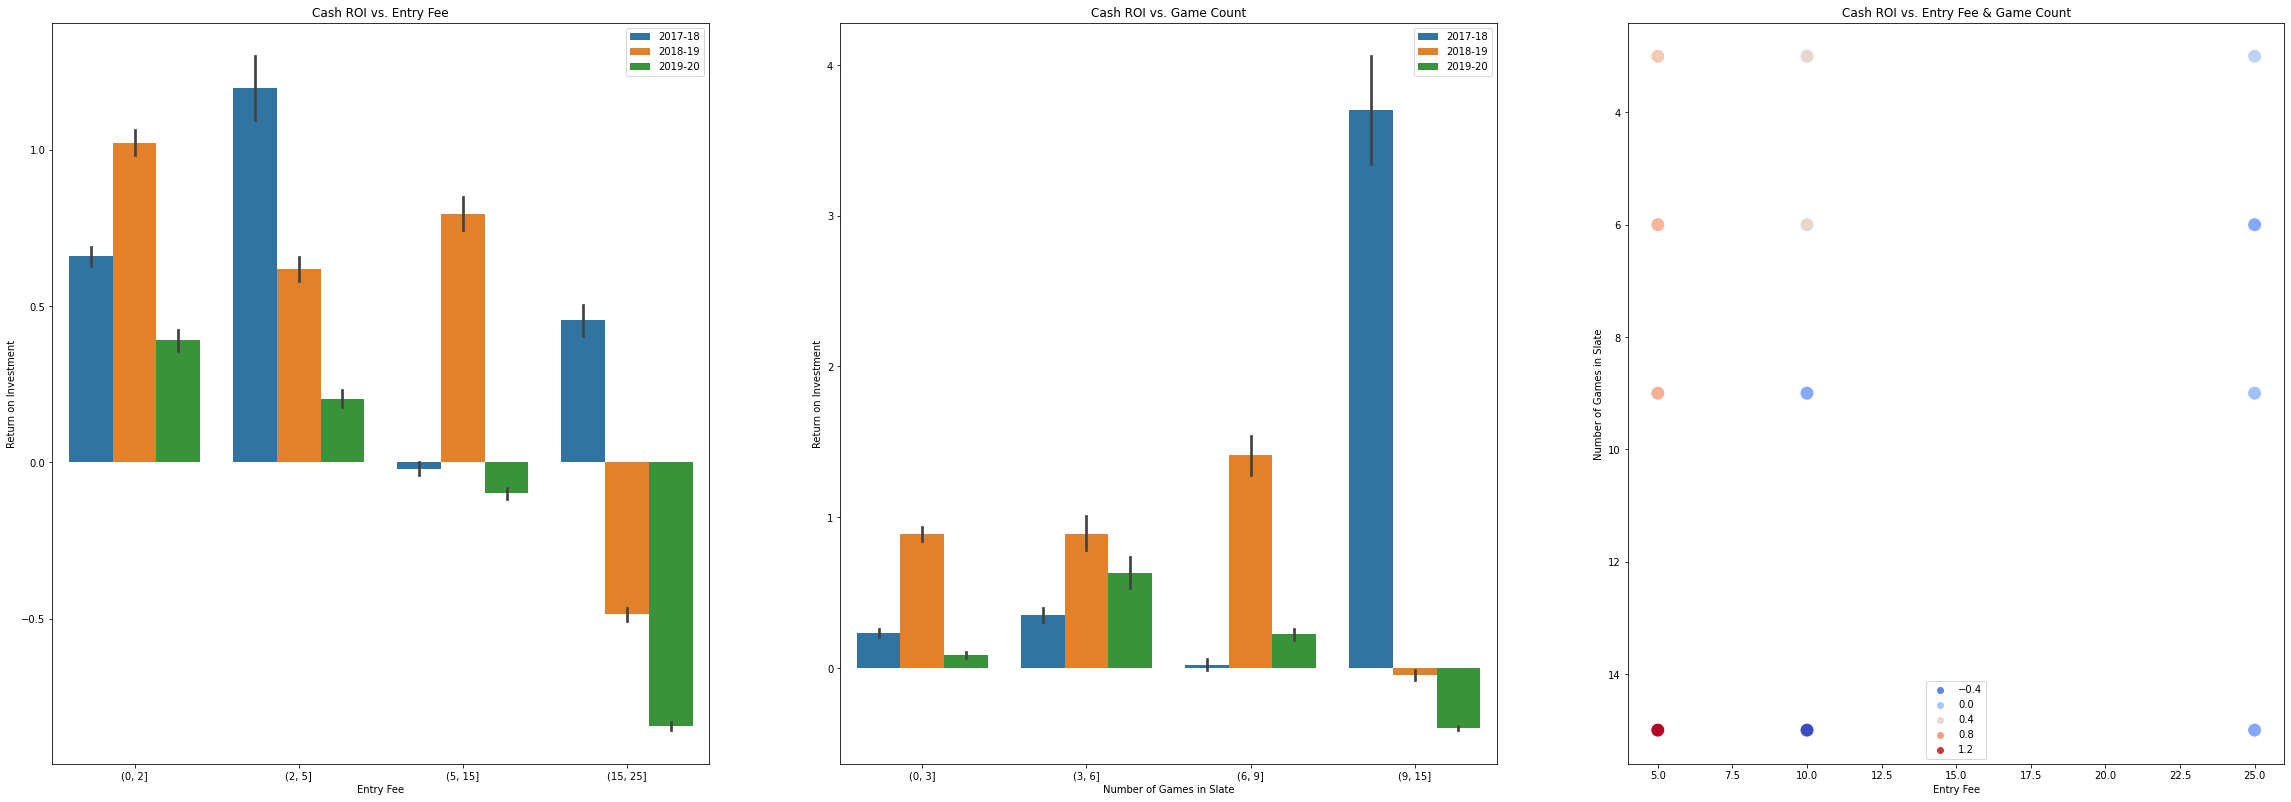

In [15]:
fig = plt.figure(1, figsize=(40, 30))
gs = fig.add_gridspec(2, 3)

# ROI vs. Entry Fee
temp = results.loc[results['LINEUP_TYPE'] == 1]
temp['ENTRY_BIN'] = pd.cut(temp['ENTRY_FEE'], bins=[0, 2, 5, 15, 25], duplicates='drop')
pnl = temp.groupby(['DATE', 'ENTRY_BIN']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum()
    })
).reset_index()
pnl = pnl.merge(player_data[['DATE', 'SEASON']], on=['DATE'], how='left')
pnl['ROI'] = (pnl['PRIZE'] - pnl['ENTRY_FEE'])/pnl['ENTRY_FEE']

ax4 = fig.add_subplot(gs[1, 0])
sns.barplot(x="ENTRY_BIN", y="ROI", hue="SEASON", data=pnl, ax=ax4)
ax4.set(xlabel="Entry Fee", ylabel="Return on Investment", title="Cash ROI vs. Entry Fee")
ax4.legend()

# ROI vs. Game Count
temp = results.loc[results['LINEUP_TYPE'] == 1]
temp['GAME_BIN'] = pd.cut(temp['GAME_COUNT'], bins=[0, 3, 6, 9, 15], duplicates='drop')
pnl = temp.groupby(['DATE', 'GAME_BIN']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum()
    })
).reset_index()
pnl = pnl.merge(player_data[['DATE', 'SEASON']], on=['DATE'], how='left')
pnl['ROI'] = (pnl['PRIZE'] - pnl['ENTRY_FEE'])/pnl['ENTRY_FEE']

ax5 = fig.add_subplot(gs[1, 1])
sns.barplot(x="GAME_BIN", y="ROI", hue="SEASON", data=pnl, ax=ax5)
ax5.set(xlabel="Number of Games in Slate", ylabel="Return on Investment", title="Cash ROI vs. Game Count")
ax5.legend()

# ROI vs. Entry Fee & Game Count
temp = results.loc[results['LINEUP_TYPE'] == 1]
temp['ENTRY_BIN'] = pd.cut(temp['ENTRY_FEE'], bins=[0, 5, 10, 25, 50, 100, 250], duplicates='drop')
temp['GAME_BIN'] = pd.cut(temp['GAME_COUNT'], bins=[0, 3, 6, 9, 15], duplicates='drop')
pnl = temp.groupby(['DATE', 'ENTRY_BIN', 'GAME_BIN']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum()
    })
).reset_index()
pnl = pnl.merge(player_data[['DATE', 'SEASON']], on=['DATE'], how='left')
pnl['ROI'] = (pnl['PRIZE'] - pnl['ENTRY_FEE'])/pnl['ENTRY_FEE']

ax6 = fig.add_subplot(gs[1, 2])
pnl['UPPER_ENTRY_FEE'] = pnl['ENTRY_BIN'].apply(lambda x: x.right)
pnl['UPPER_GAME_BIN'] = pnl['GAME_BIN'].apply(lambda x: x.right)
scat = pnl.groupby(['UPPER_GAME_BIN', 'UPPER_ENTRY_FEE']).apply(
    lambda x: pd.Series({
        'ROI': x['ROI'].mean()
    })
).reset_index()
sns.scatterplot(x='UPPER_ENTRY_FEE', y="UPPER_GAME_BIN", data=scat, hue='ROI', s=200, palette='coolwarm', ax=ax6)
ax6.set(xlabel="Entry Fee", ylabel="Number of Games in Slate", title="Cash ROI vs. Entry Fee & Game Count")
ax6.legend()

plt.show()

It is important not to overfit by cherry picking the contests in which the projections made money. To try to avoid this, I bucketed the entry fees and slate game counts. I will also only isolate a subset of contests if it makes sense why they were more profitable. The results above show that virtually no subset of cash games are profitable. On the other hand, tournaments whose entry fees are at most $1000 and slate game counts are at most 6 look profitable. This makes sense: higher entry contests attract more intelligent players, and high game slates introduce more variance.

Below I will graph the cumulative PNL of a strategy that only enters contests in the subset described above. I will also include cash games whose entry fees are at most $25 and slate game counts are at most 3 to verify the lack of edge.

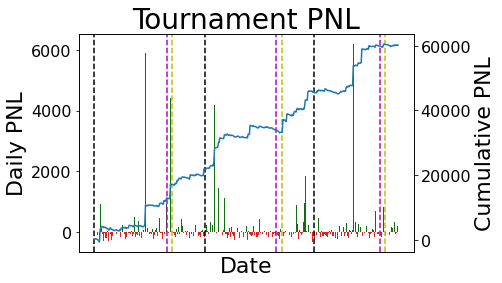

In [20]:
# fig, plt.figure(1, figsize=(30, 15))

temp = results.loc[(results['ENTRY_FEE'] < 2) & (results['LINEUP_TYPE'] == 1)]
temp['PNL'] = temp['PRIZE'] - temp['ENTRY_FEE']
pnl = temp.groupby(['DATE']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum(),
        'PNL': x['PNL'].sum()
    })
).reset_index()
pnl['RUNNING_PNL'] = pnl['PNL'].cumsum()

pnl['COLOR'] = pnl['PNL'].apply(lambda x: 'green' if x > 0 else 'red')
ax1 = sns.barplot(x=pnl.index, y='PNL', data=pnl, palette=pnl['COLOR'])
ax1.set_title('Tournament PNL', fontsize=28)

xcoords = {
    pnl.index.min(): ('2017-18 SEASON START', 'k'),
    pnl.index[pnl['DATE'] == '2018-02-08'][0]: ('2017-18 SEASON TRADE DEADLINE', 'm'),
    pnl.index[pnl['DATE'] == '2018-02-22'][0]: ('2017-18 SEASON ALL-STAR RETURN', 'y'),
    pnl.index[pnl['DATE'] == '2018-10-19'][0]: ('2018-19 SEASON START', 'k'),
    pnl.index[pnl['DATE'] == '2019-02-07'][0]: ('2018-19 SEASON TRADE DEADLINE', 'm'),
    pnl.index[pnl['DATE'] == '2019-02-21'][0]: ('2018-19 SEASON ALL-STAR RETURN', 'y'),
    pnl.index[pnl['DATE'] == '2019-10-25'][0]: ('2019-20 SEASON START', 'k'),
    pnl.index[pnl['DATE'] == '2020-02-06'][0]: ('2019-20 SEASON TRADE DEADLINE', 'm'),
    pnl.index[pnl['DATE'] == '2020-02-20'][0]: ('2019-20 SEASON ALL-STAR RETURN', 'y'),
    
}
for xcoord in xcoords:
    ax1.axvline(x=xcoord, color=xcoords[xcoord][1], linestyle='dashed')

ax2 = ax1.twinx()
sns.lineplot(x=pnl.index, y='RUNNING_PNL', data=pnl, sort=False, color='tab:blue', ax=ax2)

ax1.set_xlabel('Date', fontsize=22)
ax1.set_ylabel('Daily PNL', fontsize=22)
ax2.set_ylabel('Cumulative PNL', fontsize=22)
ax1.set_xticks([])

ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='both', labelsize=16)

plt.show()

I will only focus on tournament contests going forward. The tournament strategy seems like it may actually be profitable. However, there is a lot of variance in PNL, as the cumulative PNL depends entirely on a few days in which it hit big. Most days the strategy loses money, and there are some significant drawdowns.

Below shows the distribution of daily returns of this strategy.

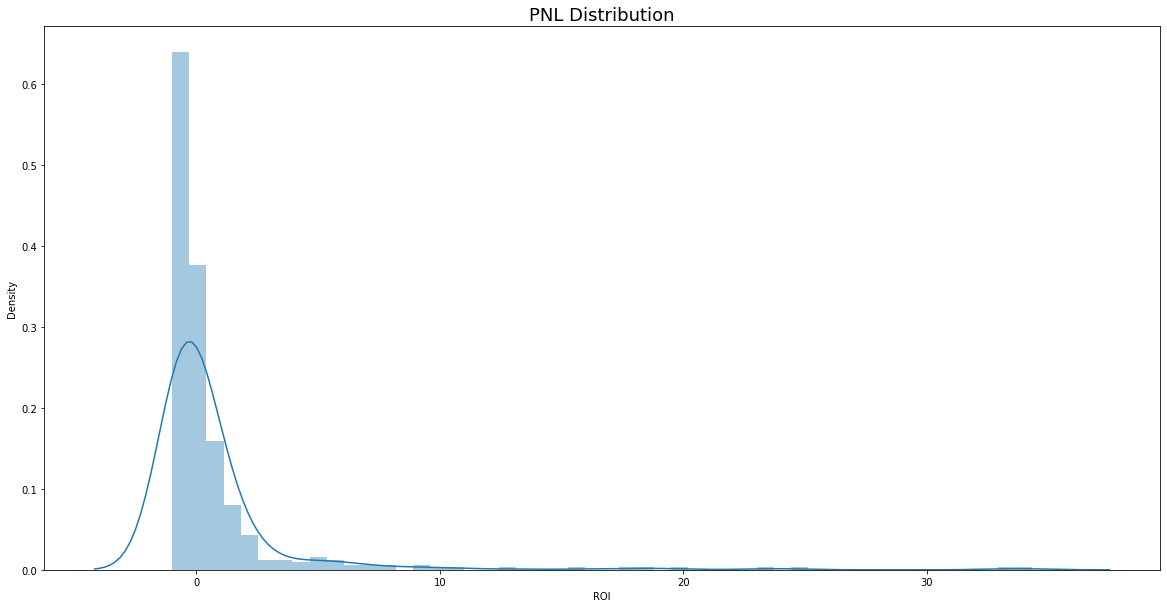

ROI Statistics:


count     463.000000
mean      130.037754
std       674.877656
min      -322.500000
25%      -111.000000
50%       -30.000000
75%        92.205000
max      6180.000000
Name: PNL, dtype: float64

In [24]:
temp = results.loc[(results['ENTRY_FEE'] < 2) & (results['LINEUP_TYPE'] == 1)]
temp['PNL'] = temp['PRIZE'] - temp['ENTRY_FEE']
pnl = temp.groupby(['DATE']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum(),
        'PNL': x['PNL'].sum()
    })
).reset_index()
pnl['ROI'] = pnl['PNL']/pnl['ENTRY_FEE']
ax = sns.distplot(pnl['ROI'])
ax.set_title('PNL Distribution', fontsize=18)
plt.rcParams["figure.figsize"] = (20, 10)
plt.show()

print('ROI Statistics:')
pnl['PNL'].describe()

In [ ]:
print(pnl['PNL'].mean())
print(pnl['PNL'].std())
print(pnl['ENTRY_FEE'].mean())

In [ ]:
from pyNBA.Data.data import QueryData
query_data = QueryData()
boxscores = query_data.query_boxscore_data()

In [ ]:
display(boxscores)

In [ ]:
from nba_api.stats.endpoints import BoxScoreAdvancedV2
box = BoxScoreAdvancedV2(game_id='0021900969').get_data_frames()[0]
nyk = box.loc[box['TEAM_ID'] == 1610612737]

In [ ]:
print(nyk['USG_PCT'].sum())

In [ ]:
display(nyk)